<a target="_blank" href="https://colab.research.google.com/github/pywavelet/pywavelet/blob/main/docs/examples/accuracy.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Accuracy checks


In [ ]:
! pip install pywavelet -q

## Monochromatic Wavelet check

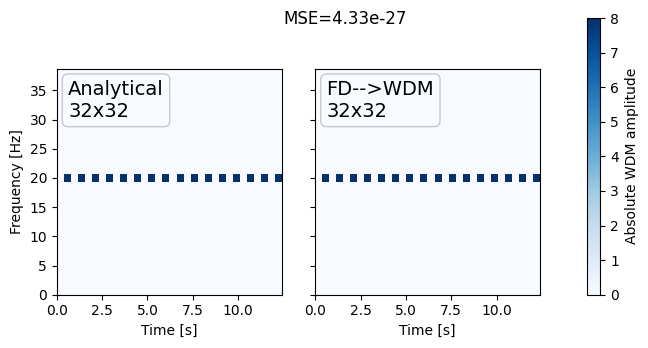

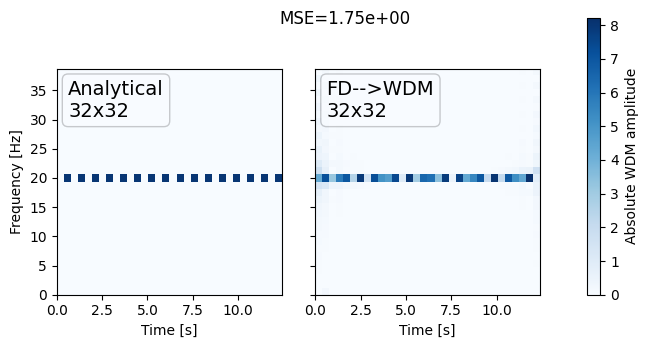

In [2]:
from pywavelet.types import Wavelet, FrequencySeries, TimeSeries
from pywavelet.types.wavelet_bins import compute_bins
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm


@dataclass
class Params:
    f0: float = 20
    dt: float = 0.0125
    A: float = 1
    Nt: int = 32
    Nf: int = 32

    @property
    def list(self):
        return [self.f0, self.dt, self.A, self.Nt, self.Nf]

    def __repr__(self):
        return f"f0={self.f0}, A={self.A}"


def monochromatic_wnm(
    f0: float,
    dt: float,
    A: float,
    Nt: int,
    Nf: int,
) -> Wavelet:
    T = Nt * Nf * dt
    N = Nt * Nf
    t_bins, f_bins = compute_bins(Nf, Nt, T)
    wnm = np.zeros((Nt, Nf))
    m0 = int(f0 * N * dt)
    f0_bin_idx = int(2 * m0 / Nt)
    odd_t_indices = np.arange(Nt) % 2 != 0
    wnm[odd_t_indices, f0_bin_idx] = A * np.sqrt(2 * Nf)
    return Wavelet(wnm.T, t_bins, f_bins)


def monochromatic_timeseries(
    f0: float,
    dt: float,
    A: float,
    Nt: int,
    Nf: int,
) -> TimeSeries:
    ND = Nt * Nf
    t = np.arange(0, ND) * dt
    y = A * np.sin(2 * np.pi * f0 * t)
    return TimeSeries(data=y, time=t)


default_params = Params()


def plot_comparison(params):

    true_wdm = monochromatic_wnm(*params.list)
    true_tdm = monochromatic_timeseries(*params.list)
    fdm = true_tdm.to_frequencyseries()
    wdm = fdm.to_wavelet(Nt=params.Nt, Nf=params.Nf)
    mse = np.mean((wdm.data - true_wdm.data) ** 2)

    fig, ax = plt.subplots(1, 2, figsize=(7, 3.5), sharex=True, sharey=True)
    norm = Normalize(vmin=0, vmax=wdm.data.max())
    kwargs = dict(absolute=True, norm=norm, cmap="Blues", show_colorbar=False)
    true_wdm.plot(ax=ax[0], **kwargs, label="Analytical")
    wdm.plot(ax=ax[1], **kwargs, label="FD-->WDM")
    ax[1].set_ylabel("")
    # set common colorbar using norm
    sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
    sm.set_array([])
    fig.colorbar(
        sm, ax=ax, orientation="vertical", label="Absolute WDM amplitude"
    )
    fig.suptitle(f"MSE={mse:.2e}")
    # tight layout whle accommodating suptitle + colorbar
    fig.tight_layout(rect=[0, 0, 0.8, 0.95])
    plt.show()


plot_comparison(Params(f0=20, A=1))
plot_comparison(Params(f0=20.1, A=1))

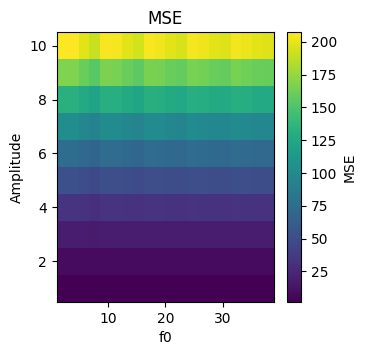

In [3]:
Namp, Nfreq = 10, 20
amplitudes = np.linspace(1, 10, Namp)
f0s = np.linspace(2, 38, Nfreq)

errors = np.zeros((Namp, Nfreq))
for i, A in enumerate(amplitudes):
    for j, f0 in enumerate(f0s):
        p = Params(f0=f0, A=A)
        true = monochromatic_wnm(*p.list)

        wdm = (
            monochromatic_timeseries(*p.list)
            .to_frequencyseries()
            .to_wavelet(Nt=p.Nt, Nf=p.Nf)
        )
        errors[i, j] = np.mean((wdm.data - true.data) ** 2)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))
# plot grid of errors as a function of amplitude and frequency
c = ax.pcolormesh(f0s, amplitudes, errors)

ax.set_xlabel("f0")
ax.set_ylabel("Amplitude")
ax.set_title("MSE")
fig.colorbar(c, ax=ax, label="MSE")

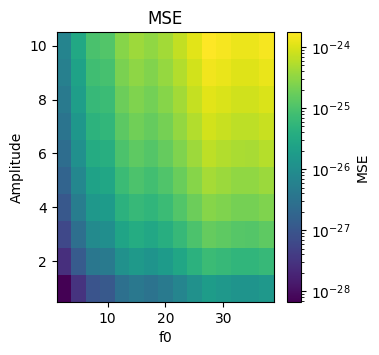

In [4]:
Namp, Nfreq = 10, 20
amplitudes = np.linspace(1, 10, Namp)
default_wdm = monochromatic_wnm(*default_params.list)
# arrange f0s such that the bin is  an integer multiple of Delta_F
f0s = default_wdm.freq[2::2]
# get midpoints of f0s

Nfreq = len(f0s)


errors = np.zeros((Namp, Nfreq))
for i, A in enumerate(amplitudes):
    for j, f0 in enumerate(f0s):
        p = Params(f0=f0, A=A)
        true = monochromatic_wnm(*p.list)

        wdm = (
            monochromatic_timeseries(*p.list)
            .to_frequencyseries()
            .to_wavelet(Nt=p.Nt, Nf=p.Nf)
        )
        errors[i, j] = np.mean((wdm.data - true.data) ** 2)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3.5))
# plot grid of errors as a function of amplitude and frequency
c = ax.pcolormesh(f0s, amplitudes, errors, norm=LogNorm())

ax.set_xlabel("f0")
ax.set_ylabel("Amplitude")
ax.set_title("MSE")
fig.colorbar(c, ax=ax, label="MSE")

## Parseval’s Theorem Test (Energy Conservation)

The total energy of a signal is the same whether calculated directly in the time domain or indirectly from its Fourier transform in the frequency domain. This means no information is lost during the transformation between time and frequency representations. 

Lets see if this holds true for the wavelet transform. We will use a simple sinusoidal signal and check if the energy in the time domain matches the energy in the frequency domain.

In [5]:
ts = monochromatic_timeseries(
    f0=20,
    dt=0.0125,
    A=1,
    Nt=32,
    Nf=32,
)
wdm = ts.to_wavelet(Nt=32)


# Calculate energy in time domain
energy_time = np.abs(ts.data) ** 2
energy_wavelet = np.abs(wdm.data) ** 2

if np.isclose(
    np.sum(energy_time), np.sum(energy_wavelet), rtol=1e-5, atol=1e-5
):
    print("Parseval's theorem holds: Energy is conserved.")
else:
    print("Parseval's theorem does not hold: Energy is not conserved.")
    print(f"Time domain energy: {np.sum(energy_time)}")
    print(f"Wavelet domain energy: {np.sum(energy_wavelet)}")

Parseval's theorem does not hold: Energy is not conserved.
Time domain energy: 512.0
Wavelet domain energy: 1024.0


## Roundtrip

In [6]:
from scipy.signal import chirp
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import os

from pywavelet.types import TimeSeries, FrequencySeries

PLOT_DIR = f"backend_plots"
os.makedirs(PLOT_DIR, exist_ok=True)


def generate_chirp_time_domain_signal(
    t: np.ndarray, freq_range: List[float]
) -> TimeSeries:
    fs = 1 / (t[1] - t[0])
    nyquist = fs / 2
    fmax = max(freq_range)
    assert (
        fmax < nyquist
    ), f"f_max [{fmax:.2f} Hz] must be less than f_nyquist [{nyquist:2f} Hz]."

    y = chirp(
        t, f0=freq_range[0], f1=freq_range[1], t1=t[-1], method="hyperbolic"
    )
    return TimeSeries(data=y, time=t)


def plot_residuals(ax, residuals):
    ax.hist(residuals, bins=100)
    # add textbox of mean and std
    mean = residuals.mean()
    std = residuals.std()
    textstr = f"$\mu={mean:.1E}$\n$\sigma={std:.1E}$"
    props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)
    ax.text(
        0.05,
        0.95,
        textstr,
        transform=ax.transAxes,
        fontsize=14,
        verticalalignment="top",
        bbox=props,
    )
    ax.set_xlabel("Residuals")
    ax.set_ylabel("Count")
    ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
    return ax


def plot(h_freq, h_reconstructed, h_wavelet, title=None):
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    _ = h_freq.plot_periodogram(ax=axes[0], color="black", label="Original")
    _ = h_reconstructed.plot_periodogram(
        ax=axes[0], ls="--", color="red", label="Reconstructed"
    )
    _ = h_wavelet.plot(ax=axes[1], absolute=True, cmap="Reds")
    _ = plot_residuals(axes[2], h_freq.data - h_reconstructed.data)
    axes[0].legend()
    axes[0].set_title("Orig[black] vs Reconstructed[red]")
    axes[1].set_title("Wavelet Domain")
    axes[2].set_title("Residuals")
    if title is not None:
        fig.suptitle(title)
    plt.tight_layout()
    # remove whitespace in 'title'
    fname = title.replace(" ", "_") if title else "roundtrip"
    fig.savefig(f"{PLOT_DIR}/{fname}.png", dpi=300, bbox_inches="tight")
    plt.close(fig)


# Sizes
dt = 1 / 512
Nt, Nf = 2**6, 2**6
mult = 16
freq_range = (10, 0.2 * (1 / dt))
ND = Nt * Nf
ts = np.arange(0, ND) * dt
h_time = generate_chirp_time_domain_signal(ts, freq_range)
h_freq = h_time.to_frequencyseries()

### Numpy

In [7]:
from pywavelet.transforms.numpy import (
    from_freq_to_wavelet,
    from_wavelet_to_freq,
)

h_wavelet = from_freq_to_wavelet(h_freq, Nf=Nf, Nt=Nt)
h_reconstructed = from_wavelet_to_freq(h_wavelet, dt=dt)
plot(h_freq, h_reconstructed, h_wavelet, title="NumPy Roundtrip")

### JAX

In [8]:
import jax

jax.config.update("jax_enable_x64", True)

from pywavelet.transforms.jax import (
    from_freq_to_wavelet as jax_from_freq_to_wavelet,
)
from pywavelet.transforms.jax import (
    from_wavelet_to_freq as jax_from_wavelet_to_freq,
)

jax_h_wavelet = jax_from_freq_to_wavelet(h_freq, Nf=Nf, Nt=Nt)
jax_h_reconstructed = jax_from_wavelet_to_freq(h_wavelet, dt=dt)
plot(h_freq, jax_h_reconstructed, jax_h_wavelet, title="JAX Roundtrip")

[15:26:59] WARNING  JAX SUBPACKAGE NOT FULLY TESTED                                                   ]8;id=508557;file:///home/avaj040/Documents/projects/pywavelet/package/src/pywavelet/transforms/jax/__init__.py\__init__.py]8;;\:]8;id=14678;file:///home/avaj040/Documents/projects/pywavelet/package/src/pywavelet/transforms/jax/__init__.py#5\5]8;;\

           INFO     Jax running on cpu [64bit precision].                                            ]8;id=833239;file:///home/avaj040/Documents/projects/pywavelet/package/src/pywavelet/transforms/jax/__init__.py\__init__.py]8;;\:]8;id=93510;file:///home/avaj040/Documents/projects/pywavelet/package/src/pywavelet/transforms/jax/__init__.py#21\21]8;;\

### CuPy

In [9]:
from pywavelet.backend import cuda_is_available

if not cuda_is_available():
    print(
        "CuPy backend is not available. Please install CuPy with CUDA support."
    )
else:
    from pywavelet.transforms.cupy import (
        from_freq_to_wavelet as cp_from_freq_to_wavelet,
    )
    from pywavelet.transforms.cupy import (
        from_wavelet_to_freq as cp_from_wavelet_to_freq,
    )

    cp_h_wavelet = cp_from_freq_to_wavelet(h_freq, Nf=Nf, Nt=Nt)
    cp_h_reconstructed = cp_from_wavelet_to_freq(h_wavelet, dt=dt)
    plot(h_freq, cp_h_reconstructed, cp_h_wavelet, title="CuPy Roundtrip")

CuPy backend is not available. Please install CuPy with CUDA support.


### Results

| Backend | Roundtrip Plot |
|:---:|:---:|
| NumPy | ![NumPy Roundtrip][numpy] |
| JAX | ![JAX Roundtrip][jax] |
| CuPy | ![CuPy Roundtrip][cupy] |


 
[jax]: backend_plots/JAX_Roundtrip.png
[numpy]: backend_plots/NumPy_Roundtrip.png
[cupy]: backend_plots/CuPy_Roundtrip.png 

## Noise robustness

In [ ]:
import numpy as np
from pywavelet.types import TimeSeries, FrequencySeries
from time import process_time

np.random.seed(42)  # For reproducibility


def generate_white_noise(
    N: int = 2**20, scale: float = 1.0
) -> FrequencySeries:
    """Generate white noise time series."""
    noise = np.random.normal(0, scale, N)
    return TimeSeries(data=noise, time=np.arange(N)).to_frequencyseries()


datasets = [generate_white_noise() for _ in range(100)]


def get_residuals(datasets, forward_transform, inverse_transform, Nf=2**10):
    mse = np.zeros((len(datasets), 2))
    for i, h_freq in enumerate(datasets):
        t0 = process_time()
        h_wavelet = forward_transform(h_freq, Nf=Nf)
        h_reconstructed = inverse_transform(h_wavelet, dt=h_time.dt)
        mse[i, 0] = get_mse(h_freq, h_reconstructed)
        mse[i, 1] = process_time() - t0

    return mse[1:].T


def get_mse(f1, f2):
    """Calculate Mean Squared Error between two frequency series."""
    return float(np.mean((np.abs(f1.data - f2.data) ** 2)[1:-1]))


numpy_mses = get_residuals(
    datasets, from_freq_to_wavelet, from_wavelet_to_freq
)

jax_mses = get_residuals(
    datasets, jax_from_freq_to_wavelet, jax_from_wavelet_to_freq
)


cp_mses = None
if cuda_is_available():
    from pywavelet.transforms.cupy import (
        from_freq_to_wavelet as cp_from_freq_to_wavelet,
    )
    from pywavelet.transforms.cupy import (
        from_wavelet_to_freq as cp_from_wavelet_to_freq,
    )

    cp_mses = get_residuals(
        datasets, cp_from_freq_to_wavelet, cp_from_wavelet_to_freq
    )

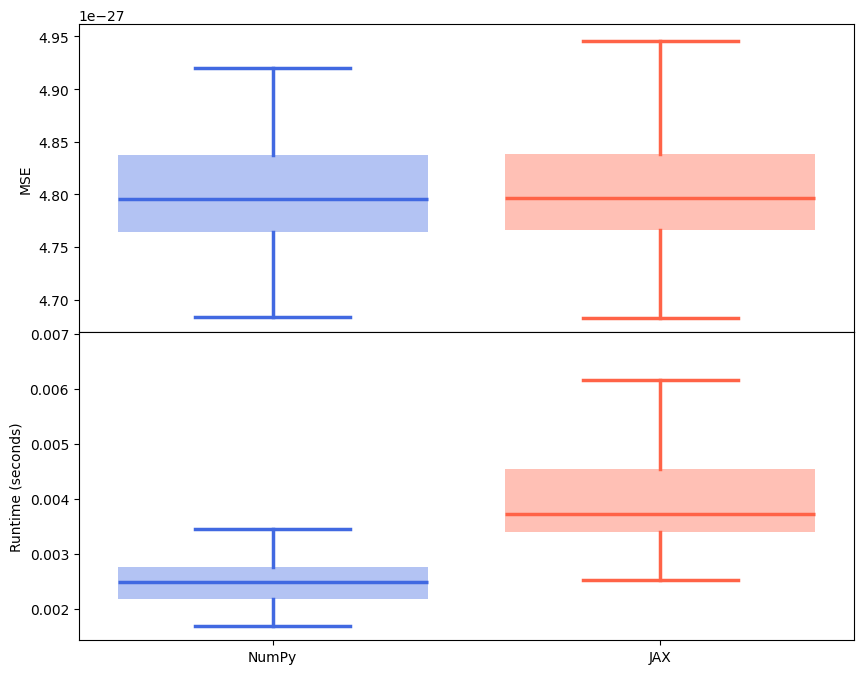

In [11]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt

# Set the desired RC parameters
rc_params = {
    "xtick.direction": "in",  # Mirrored ticks (in and out)
    "ytick.direction": "in",
    "xtick.top": True,  # Show ticks on the top spine
    "ytick.right": True,  # Show ticks on the right spine
    "xtick.major.size": 6,  # Length of major ticks
    "ytick.major.size": 6,
    "xtick.minor.size": 4,  # Length of minor ticks
    "ytick.minor.size": 4,
    "xtick.major.pad": 4,  # Padding between tick and label
    "ytick.major.pad": 4,
    "xtick.minor.pad": 4,
    "ytick.minor.pad": 4,
    "font.size": 14,  # Overall font size
    "axes.labelsize": 16,  # Font size of axis labels
    "axes.titlesize": 18,  # Font size of plot title
    "xtick.labelsize": 12,  # Font size of x-axis tick labels
    "ytick.labelsize": 12,  # Font size of y-axis tick labels
    "xtick.major.width": 2,  # Thickness of major ticks
    "ytick.major.width": 2,  # Thickness of major ticks
    "xtick.minor.width": 1,  # Thickness of minor ticks
    "ytick.minor.width": 1,  # Thickness of minor ticks
    "lines.linewidth": 3,  # Default linewidth for lines in plots
    "patch.linewidth": 4,  # Default linewidth for patches (e.g., rectangles, circles)
    "axes.linewidth": 2,  # Default linewidth for the axes spines
}

# Apply the RC parameters globally
plt.rcParams.update(rc_params)

COLORS = dict(teal="#17becf", gray="#c9c9c9", red="#d62728")

# Data setup
MSE = [numpy_mses[0], jax_mses[0]] + (
    [cp_mses[0]] if cp_mses is not None else jax_mses[0]
)
runtimes = [numpy_mses[1], jax_mses[1]] + (
    [cp_mses[1]] if cp_mses is not None else jax_mses[1]
)

labels = ["NumPy", "JAX"] + (["CuPy"] if cp_mses is not None else [])
colors = ["#d62728", "#17becf"] + (["#c9c9c9"] if cp_mses is not None else [])
positions = np.arange(len(labels)) * 1.0  # Spaced positions

fig, axes = plt.subplots(2, 1, figsize=(4, 5), sharex=True)


# Plot helper
def make_boxplot(ax, data, title, ylabel):
    for i, d in enumerate(data):
        ax.boxplot(
            d,
            positions=[positions[i]],
            widths=0.8,
            patch_artist=True,
            boxprops=dict(
                facecolor=colors[i], alpha=0.4, color=colors[i], linewidth=0
            ),
            medianprops=dict(color=colors[i], linewidth=2.5),
            whiskerprops=dict(color=colors[i], linewidth=2.5),
            capprops=dict(color=colors[i], linewidth=2.5),
            flierprops=dict(
                marker="o", color=colors[i], alpha=0.6, markersize=0
            ),
        )
    # ax.set_title(title)
    ax.set_ylabel(ylabel)
    # ax.grid(axis="y", linestyle="--", alpha=0.4)


make_boxplot(axes[0], MSE, "Mean Squared Errors (MSEs)", "MSE")
make_boxplot(axes[1], runtimes, "Runtimes", "Runtime [s]")

axes[1].set_xticks(positions)
axes[1].set_xticklabels(labels)

# remove whitespace between subplots
plt.subplots_adjust(hspace=0)


# plt.tight_layout()
plt.savefig("mes.pdf", dpi=300, bbox_inches="tight")
plt.show()